In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from matplotlib.collections import LineCollection
from sklearn.metrics import RocCurveDisplay
from pycaret.anomaly import *
from sklearn.preprocessing import MinMaxScaler
# from pycaret.classification import *

In [2]:
files = ['arp','combination','injection','readbomb','recon','synflood','malware']

col = ['time', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'ip.len', 'ip.id', 'ip.flags', 'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.hdr_len', 'tcp.flags', 'tcp.window_size', 'tcp.time_delta', 'tcp.time_relative', 'attack']
data = []
time = []
file_entropy = []
attack_entropy = []
for file in files:
    temp_data = pd.read_csv('testsets/raw/raw_'+file+'.csv')
    data.append(temp_data)
    temp_time = temp_data['time'].unique().shape[0]
    time.append(temp_time)
    file_entropy.append(np.zeros((temp_time,temp_data.shape[1])))
    attack_entropy.append(np.zeros((temp_time,)))


In [3]:
def calc_entropy(value):
    uvalue,counts = np.unique(value, return_counts=True)
    if value.shape[0] > 1:
        return entropy(counts)
    else :
        return -1

def get_entropy(column,i,df):
    temp = df.loc[df['time'] == i]
    return calc_entropy(temp[column])

In [4]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [5]:
for f in range(len(files)):
    for i in range(time[f]):
        result = [get_entropy(col[j],i,data[f]) for j in range(1,len(col))]
        if -1 not in result:
            file_entropy[f][i,1:] = result

    file_entropy[f] = file_entropy[f][~np.any(file_entropy[f] == -1, axis=1)]
    file_entropy[f] = file_entropy[f][~np.all(file_entropy[f] == 0, axis=1)]
    attack_entropy[f] = file_entropy[f][:,-1]
    
    to_file = pd.DataFrame(file_entropy[f])
    to_file.columns = col
    to_file.to_csv(files[f]+'_entropy.csv', index=False)
    attack_to_file = pd.DataFrame(attack_entropy[f])
    attack_to_file.columns = ['attack']
    attack_to_file.to_csv(files[f]+'_attack.csv', index=False)

# for f in range(len(files)):
#     file_entropy[f] = pd.read_csv('testsets/entropy/'+files[f]+'_entropy.csv').to_numpy()
# #     ics_entropy = ics_entropy.drop(['ip.flags'],axis=1)
# #     col = ics_entropy.columns
# #     ics_entropy = ics_entropy.to_numpy()
#     attack_entropy[f] = pd.read_csv('testsets/entropy/'+files[f]+'_attack.csv').to_numpy()

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
attack_time = []
for f in range(len(files)):
    file_entropy[f] = scaler.fit_transform(file_entropy[f])    
    attack_time.append(np.asarray(np.where(attack_entropy[f] > 0))[0])

In [7]:
smooth_entropy = [file_entropy[i].copy() for i in range(len(file_entropy))]
# smooth_ics = smooth_ics[:,4500:,:]
for f in range(len(files)):
    for i in range(smooth_entropy[f].shape[1]):
        smooth_entropy[f][:,i] = smooth(smooth_entropy[f][:,i],1000)

for f in range(len(files)):
    smooth_entropy[f] = smooth_entropy[f][1000:-500,:]
    for j in range(len(smooth_entropy[f][:,-1])):
        if smooth_entropy[f][j,-1] > 0:
            smooth_entropy[f][j,-1] = 1
    
#arp : 1000,1000,-500,0.056  
#combination : 1000,1000,-500,0.056 
#injection : 1000,1000,-500, 0.052
#readbomb : 1000,1000,-500, 0.054
#recon : 1000,1000,-500, 0.054
#synflood : 1000,1000,-500, 0.054
#malware : 1000,1000,-500, 0.058

In [8]:
smooth_time = []
for f in range(len(files)):
    smooth_time.append(np.asarray(np.where(smooth_entropy[f][:,-1] == 1))[0])
    
smooth_time = np.asarray(smooth_time)

f=0

In [9]:
# for i in range(1,file_entropy[f].shape[1]-1):
#     x = range(file_entropy[f].shape[0])
#     y = file_entropy[f][:,i]
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)

#     cm = dict(zip(range(0,2,1),list("br")))
#     colors = list( map( cm.get , np.isin(x,attack_time[f]) ))

#     lc = LineCollection(segments, colors=colors, linewidths= 1)
#     fig, ax = plt.subplots()
#     ax.add_collection(lc)

#     ax.autoscale()
#     ax.margins(0.1)
#     plt.xlabel('Time')
#     plt.ylabel(col[i])
#     plt.show()

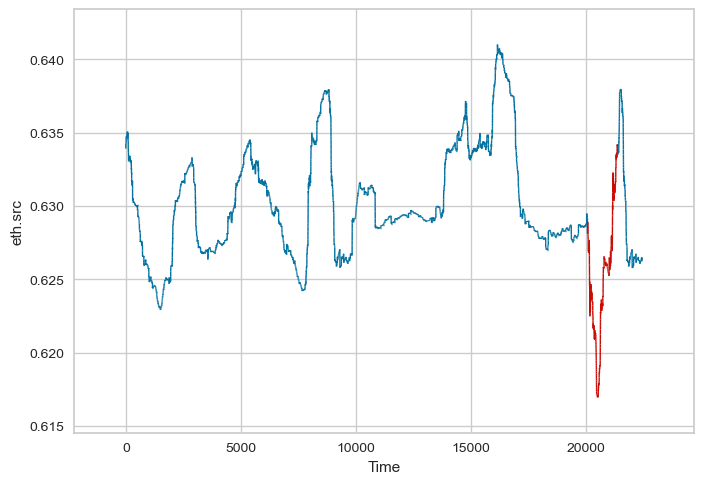

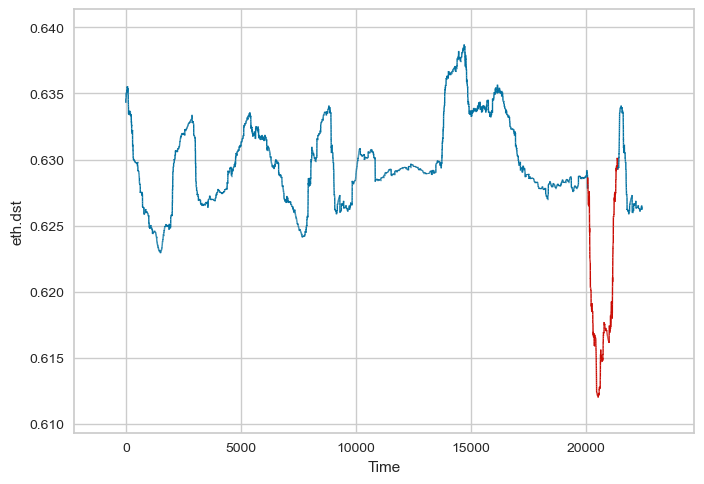

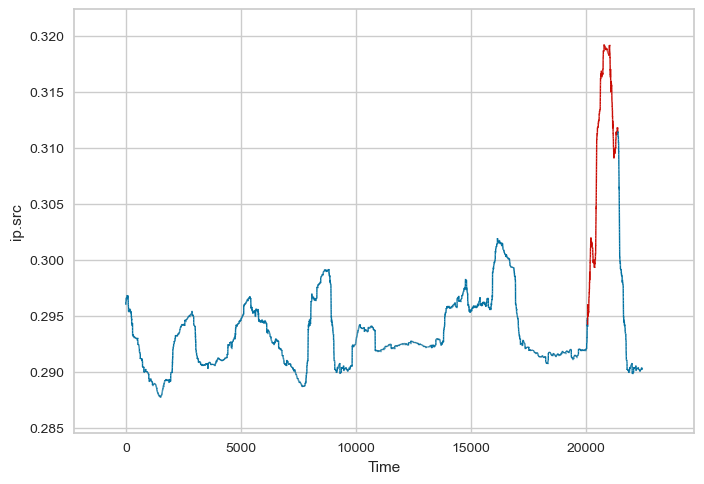

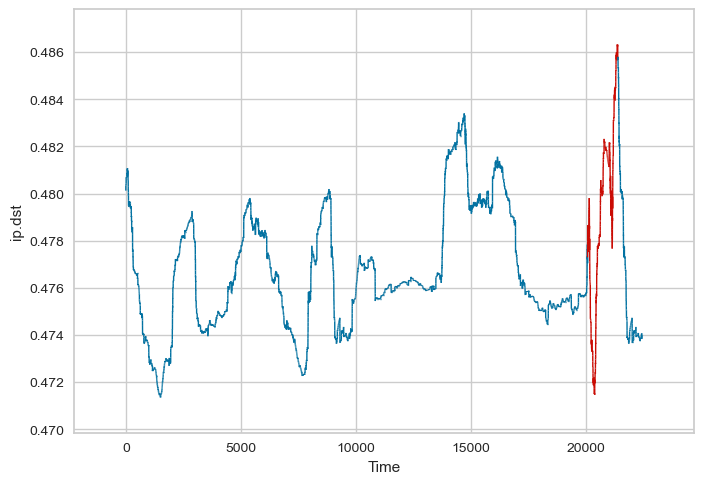

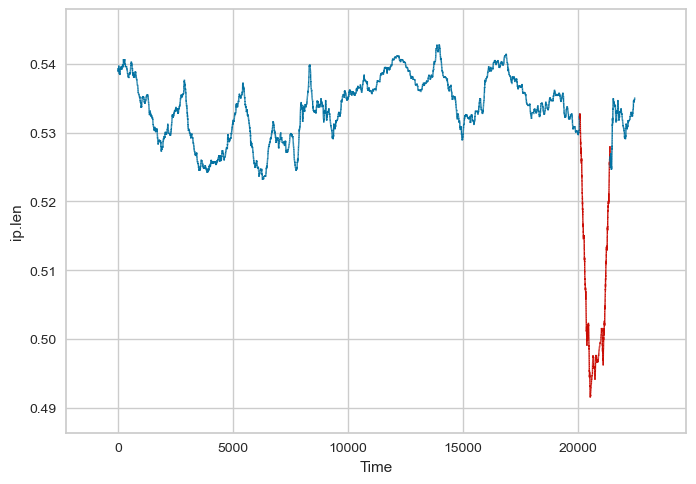

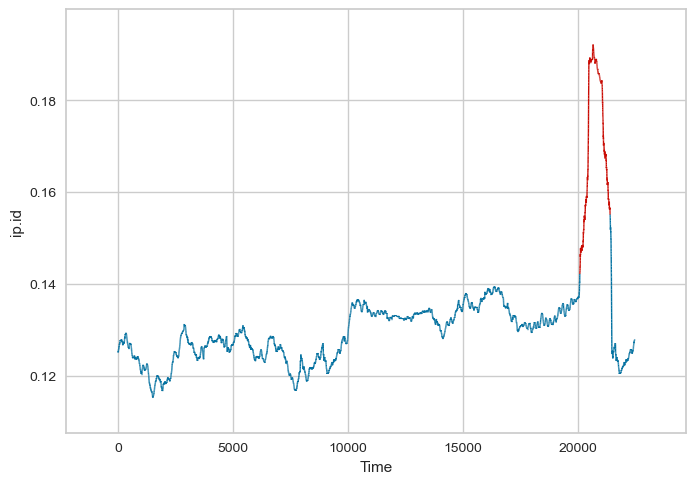

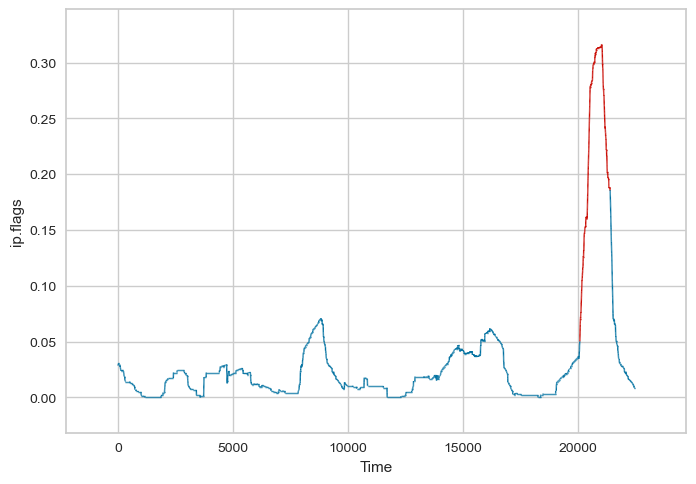

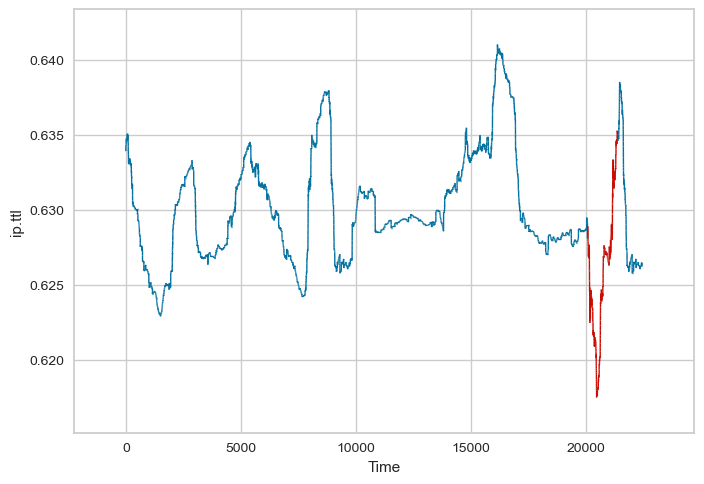

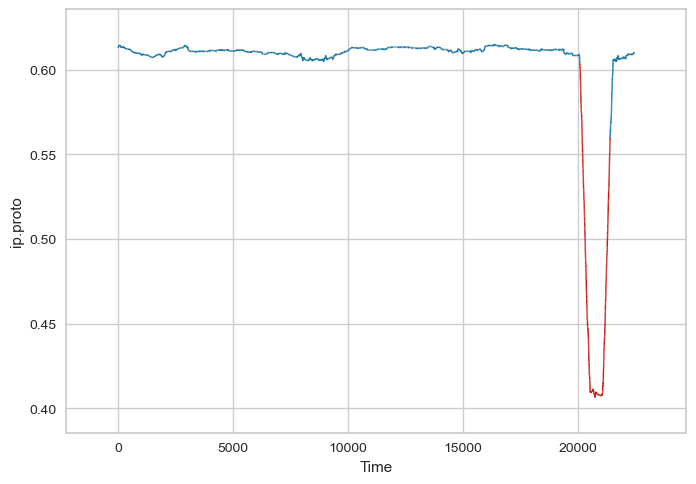

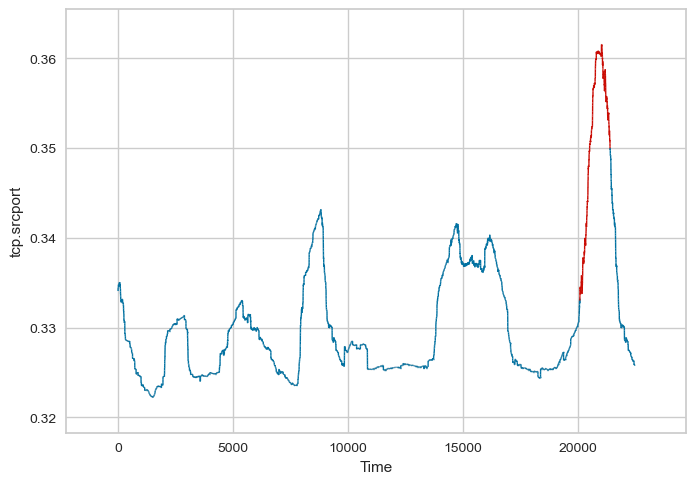

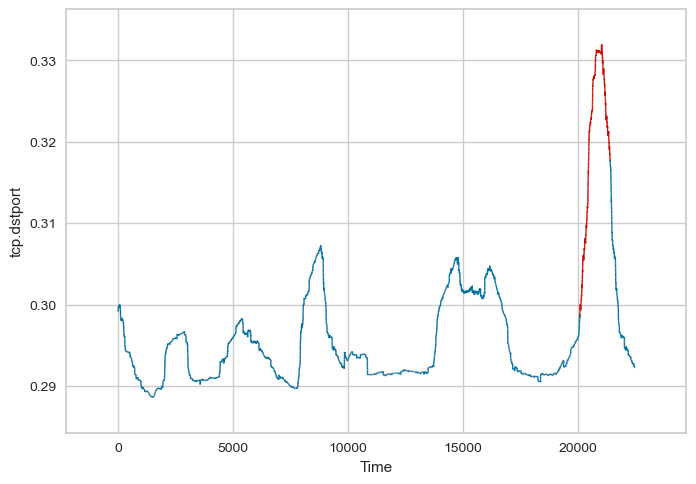

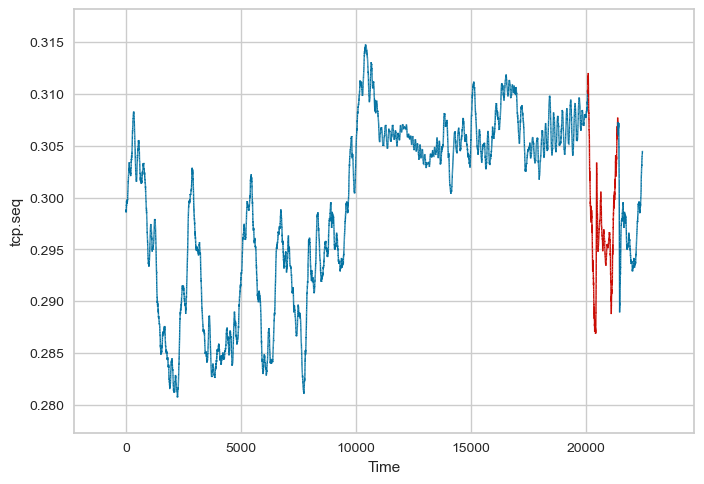

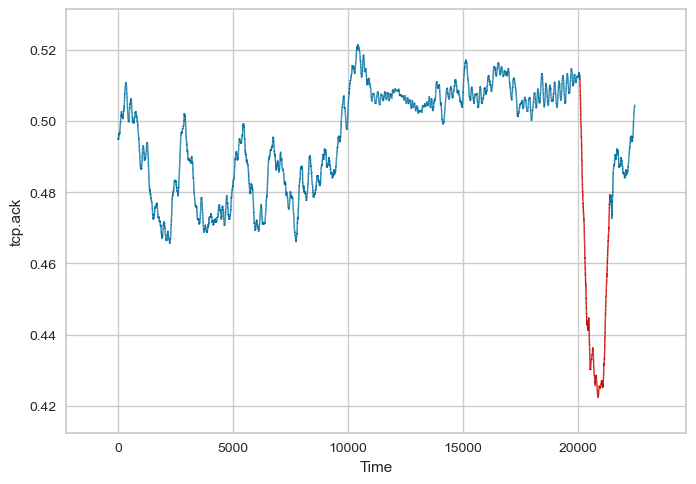

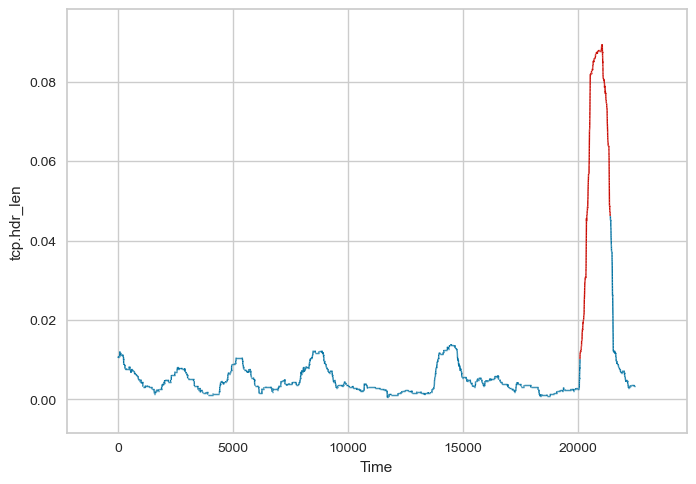

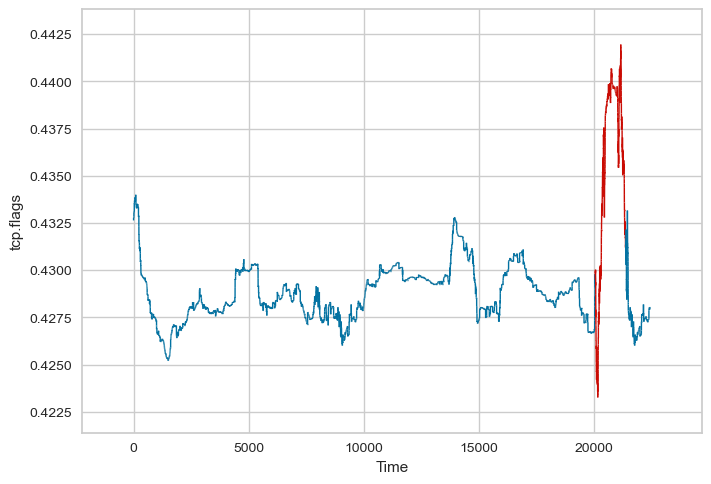

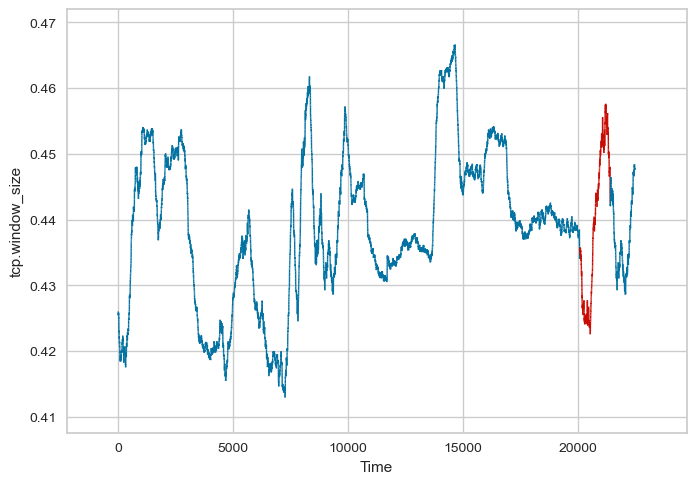

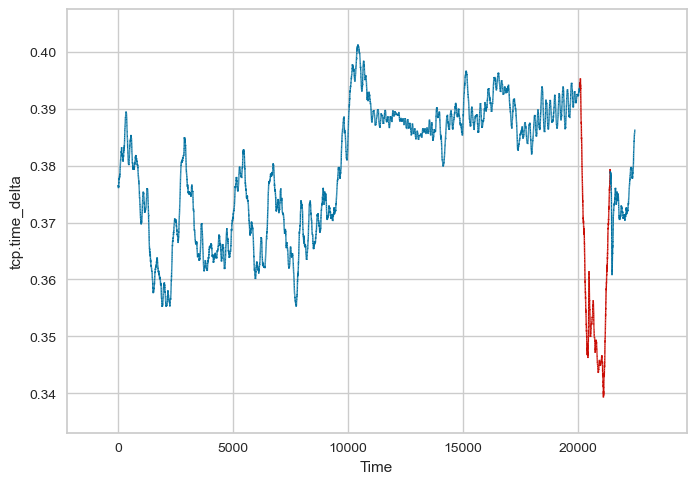

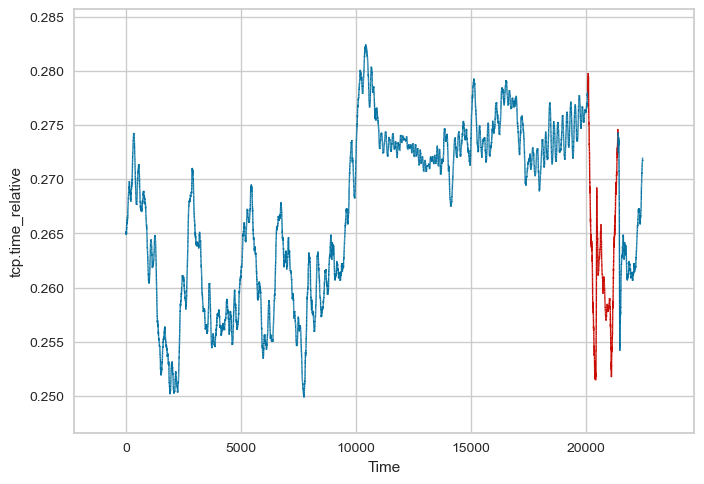

In [9]:
for i in range(1,len(col)-1):
    x = range(smooth_entropy[f].shape[0])
    y = smooth_entropy[f][:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,smooth_time[f]) ))

    lc = LineCollection(segments, colors=colors, linewidths=1)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

In [10]:
# X = pd.DataFrame(smooth_ics[:,1:])
X = pd.DataFrame(smooth_entropy[f][:,1:-1])
X.columns = col[1:-1]
# X.columns = col[1:]
setup(X,session_id=123)
# setup(X,target='attack',fix_imbalance = True,feature_selection=True)

('lightgbm',
 False,
 <MLUsecase.ANOMALY: 4>,
 KFold(n_splits=10, random_state=None, shuffle=False),
 [('Setup Config',
                                  Description                 Value
   0                               session_id                   123
   1                            Original Data           (22467, 18)
   2                           Missing Values                 False
   3                         Numeric Features                    18
   4                     Categorical Features                     0
   5                         Ordinal Features                 False
   6                High Cardinality Features                 False
   7                  High Cardinality Method                  None
   8                         Transformed Data           (22467, 18)
   9                                 CPU Jobs                    -1
   10                                 Use GPU                 False
   11                          Log Experiment                 Fa

In [ ]:
# models()
# model = compare_models()

In [18]:
iforest = create_model('iforest', fraction = 0.058)
iforest_result = assign_model(iforest)
anomaly = iforest_result['Anomaly']
anomaly.to_csv('plot/'+files[f]+'_anomaly_value.csv', index=False)
pd.DataFrame(smooth_entropy[f][:,-1]).to_csv('plot/'+files[f]+'_true_value.csv', index=False)
# plot = RocCurveDisplay.from_predictions(attack_entropy[:,1],anomaly,pos_label=1,name='ROC curve',linewidth=1.5)
# plot.set_xlabel("False Positive Rate")
# plot.set_ylabel("True Positive Rate")
TP = 0
FP = 0
TN = 0
FN = 0
fp_time = []
fn_time = []
for i in range(smooth_entropy[f].shape[0]):
    if i not in smooth_time[f] and anomaly[i]==0:
        TN += 1
    elif i in smooth_time[f] and anomaly[i]==1:
        TP += 1
    elif i in smooth_time[f] and anomaly[i]==0:
        FN += 1
        fn_time.append(i)
    elif i not in smooth_time[f] and anomaly[i]==1:
        FP += 1
        fp_time.append(i)

print("True positive =",TP)
print("False positive =",FP)
print("True negative =",TN)
print("False negative =",FN)

True positive = 1224
False positive = 80
True negative = 21071
False negative = 92


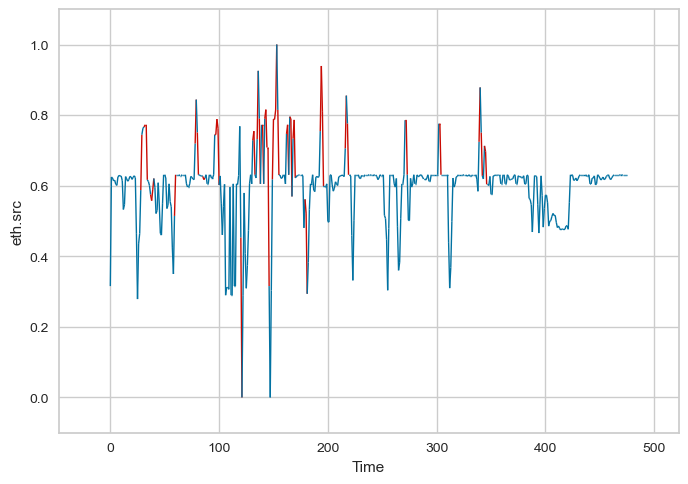

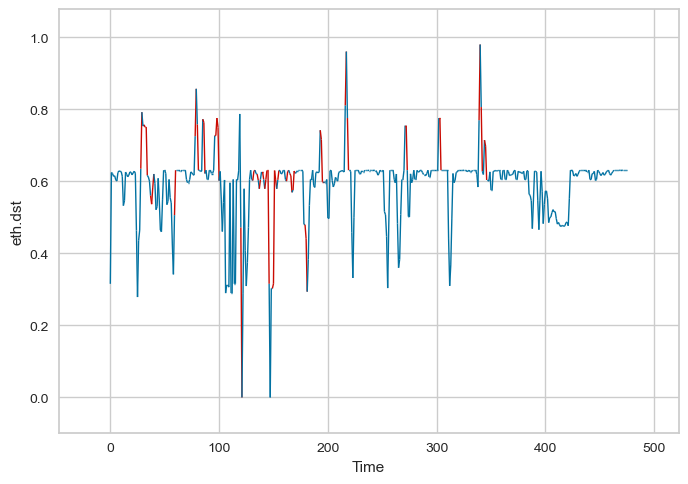

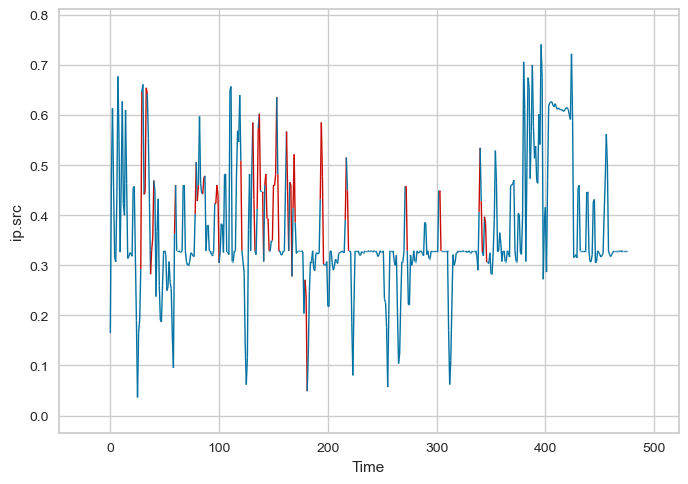

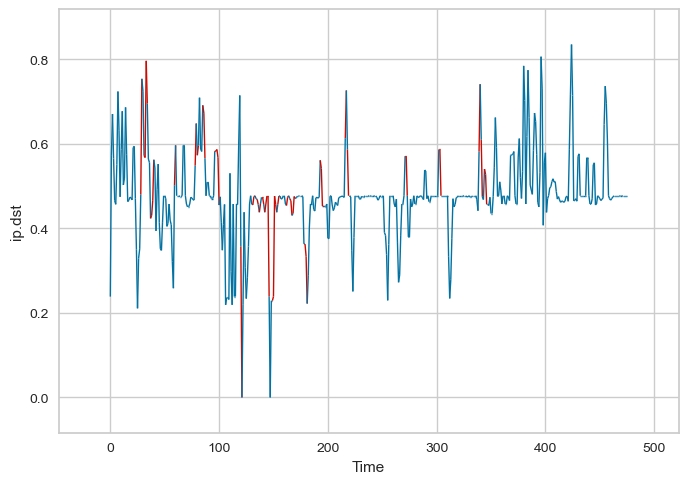

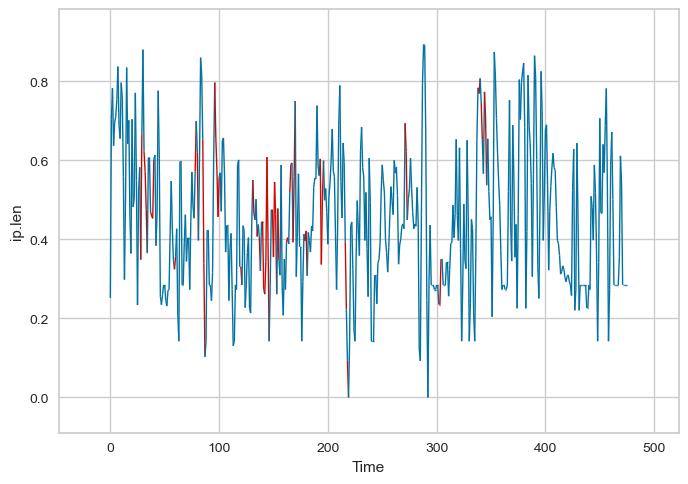

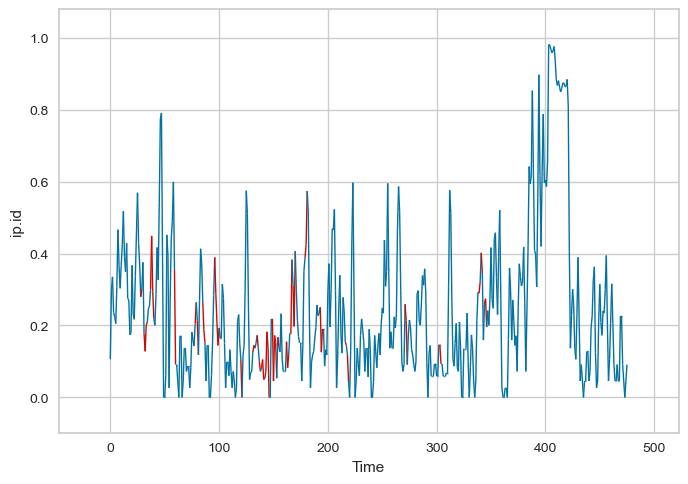

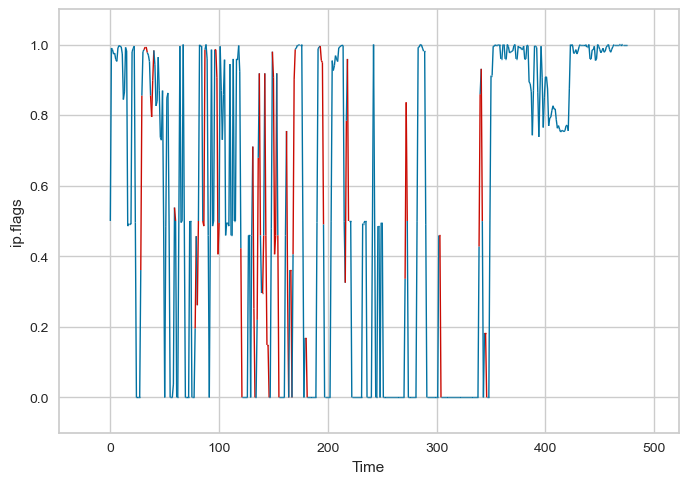

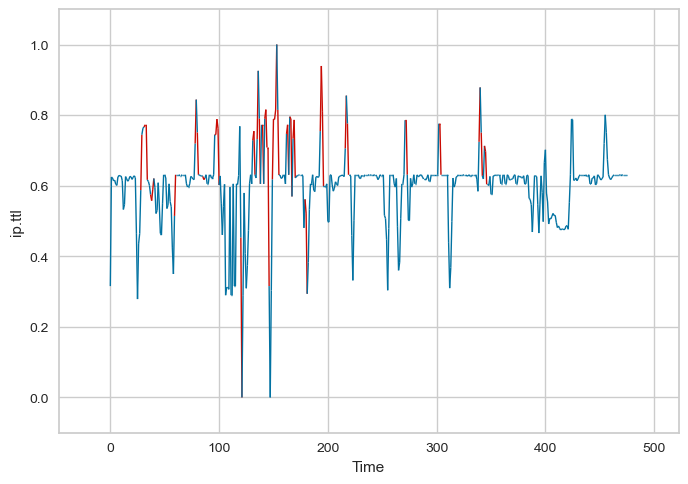

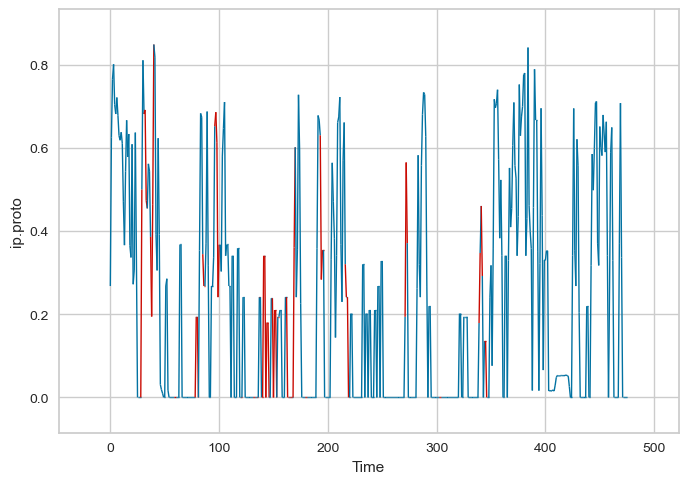

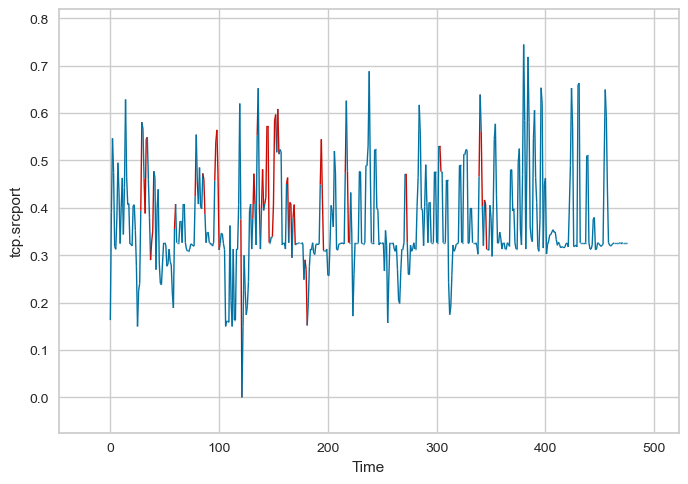

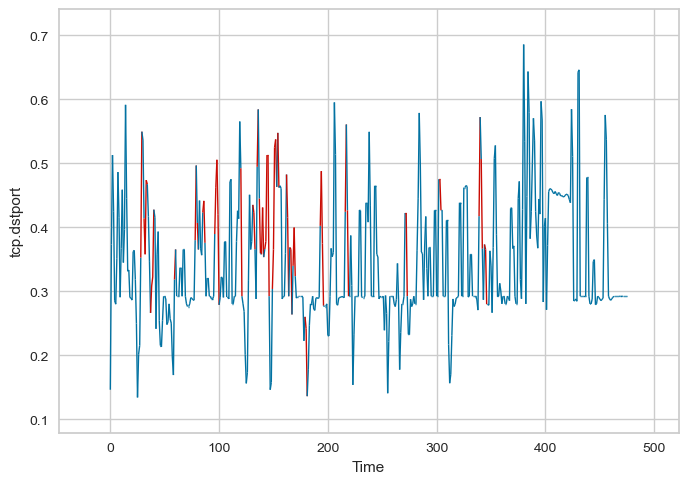

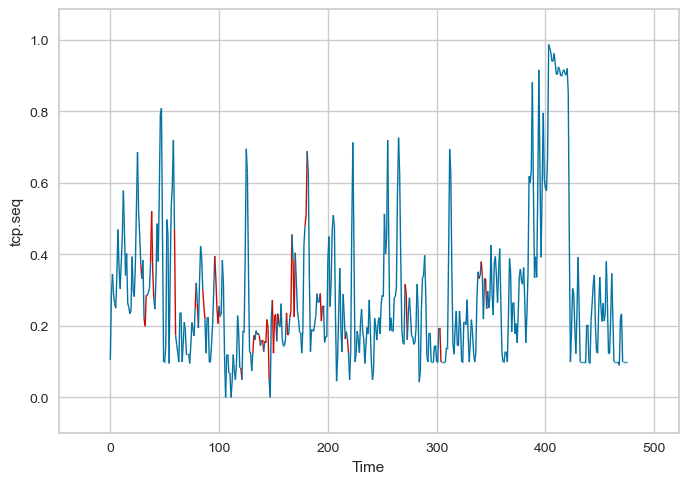

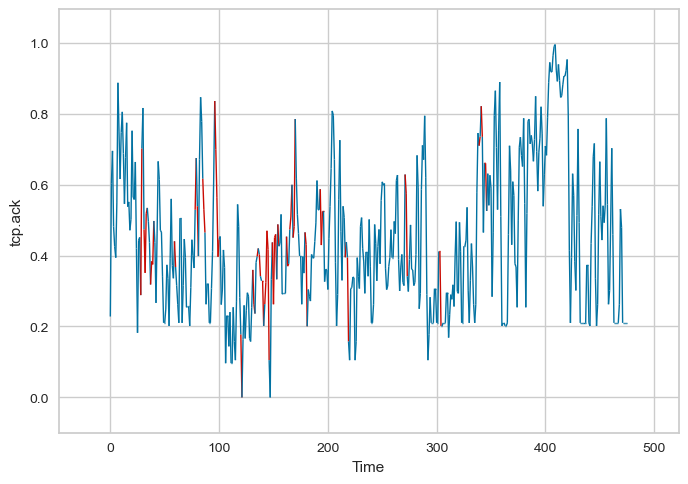

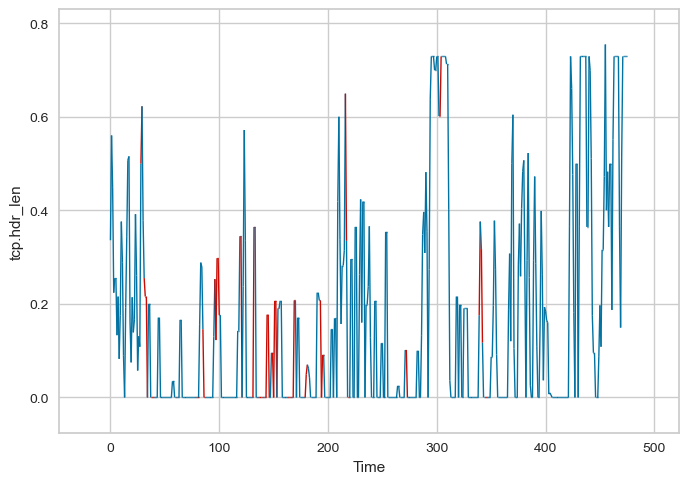

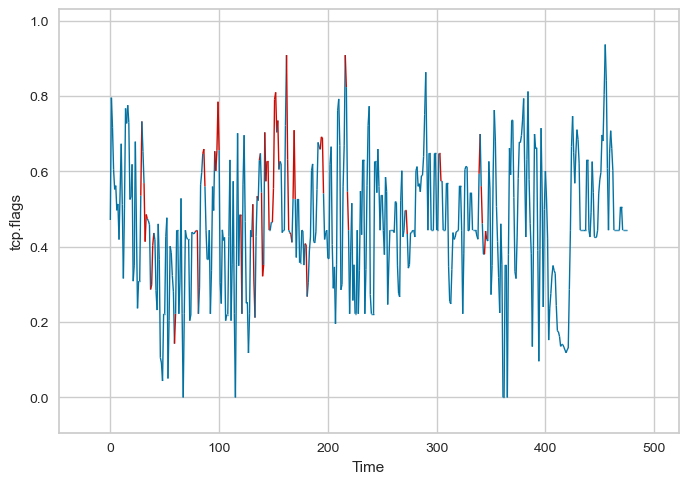

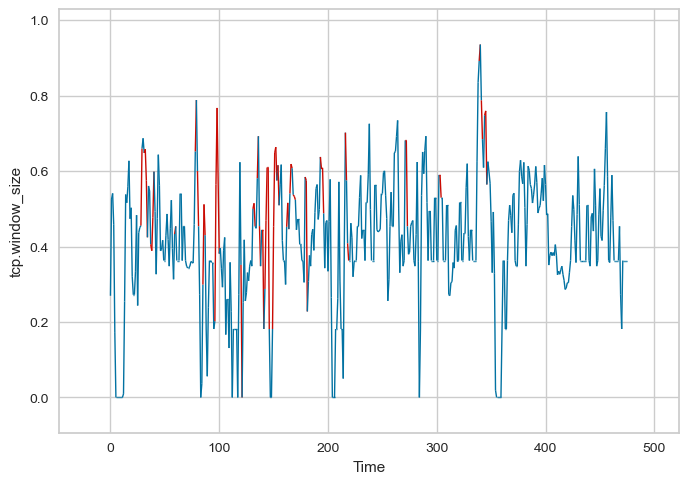

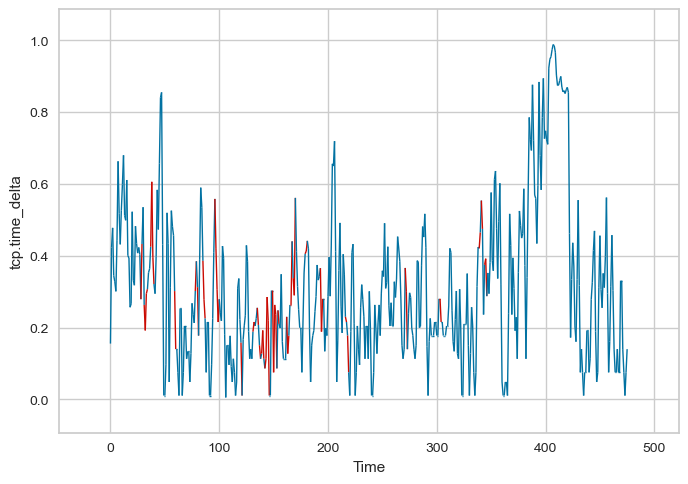

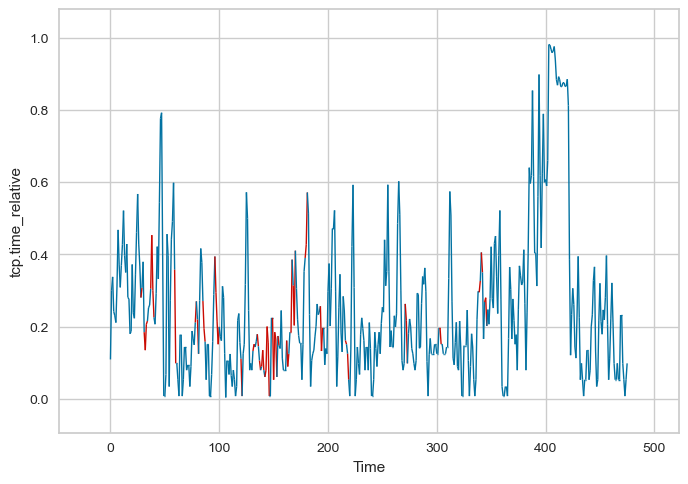

In [14]:
for i in range(1,len(col)-1):
    x = range(smooth_entropy[f].shape[0])
    y = smooth_entropy[f][:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,fn_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

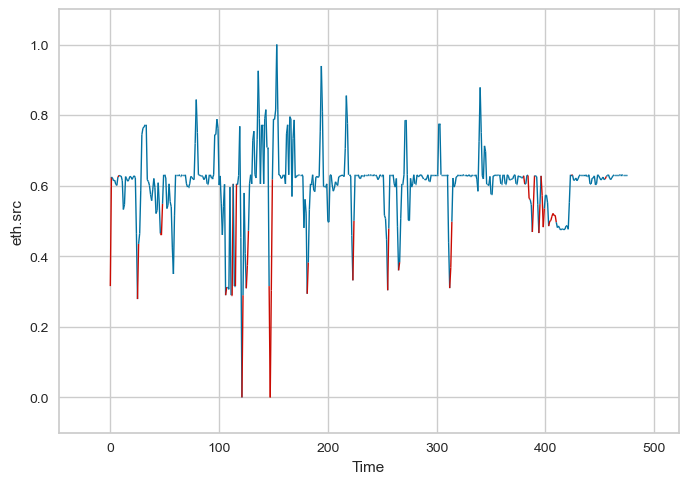

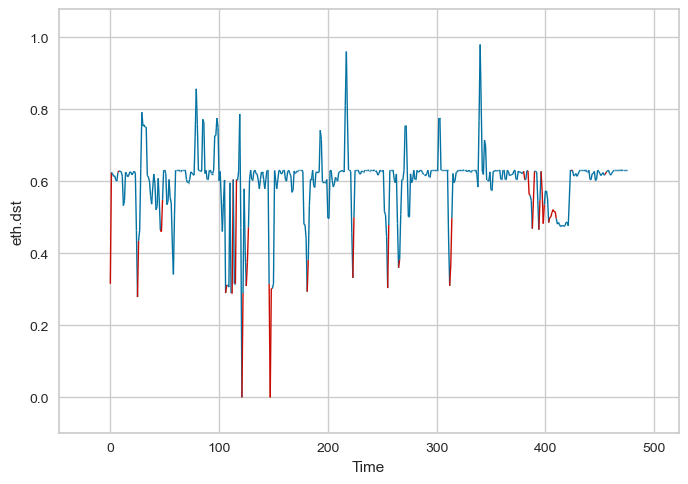

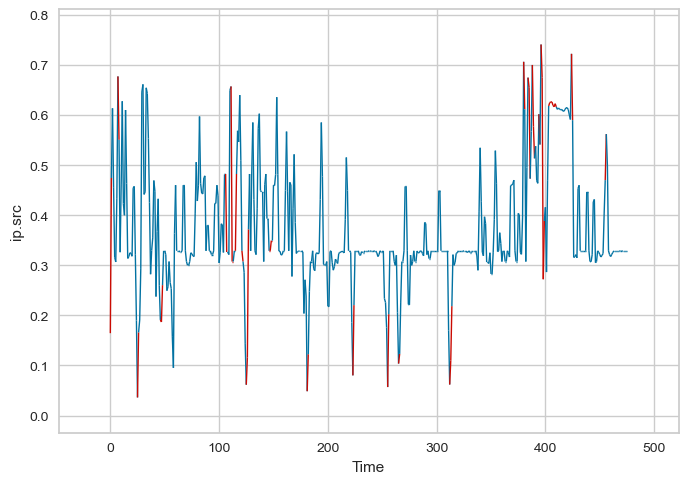

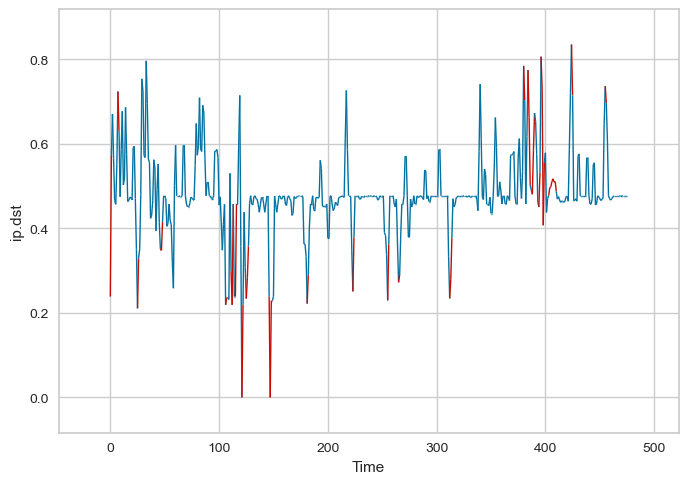

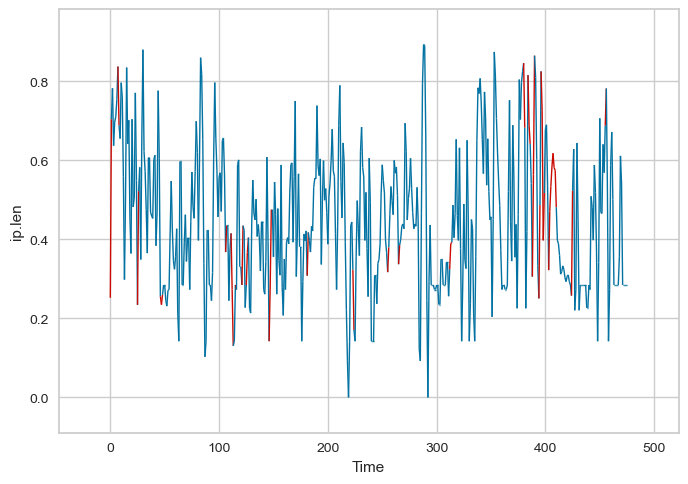

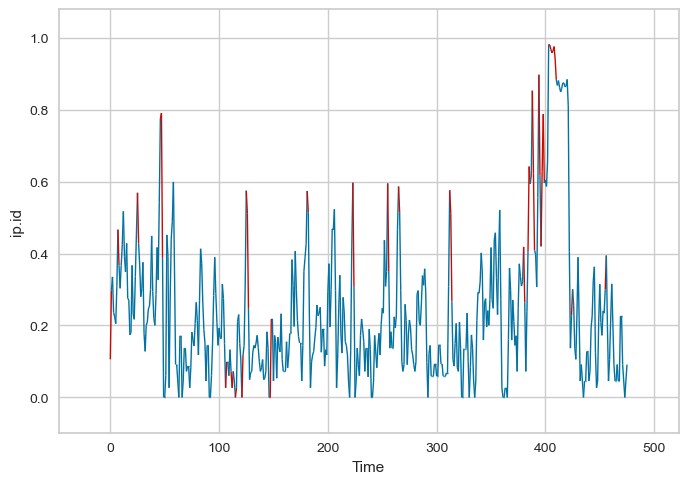

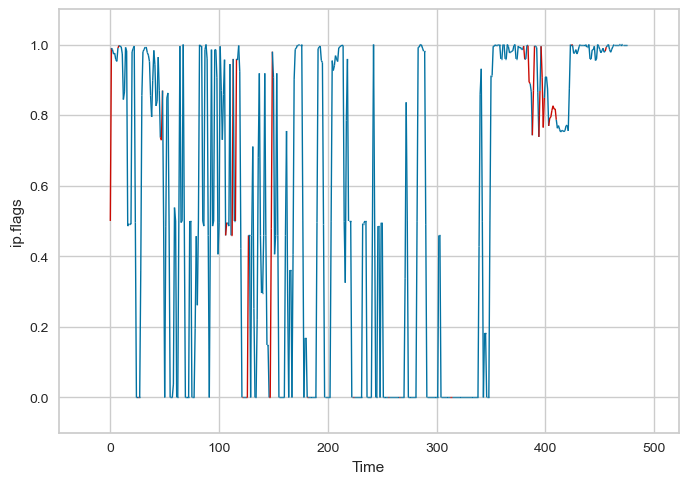

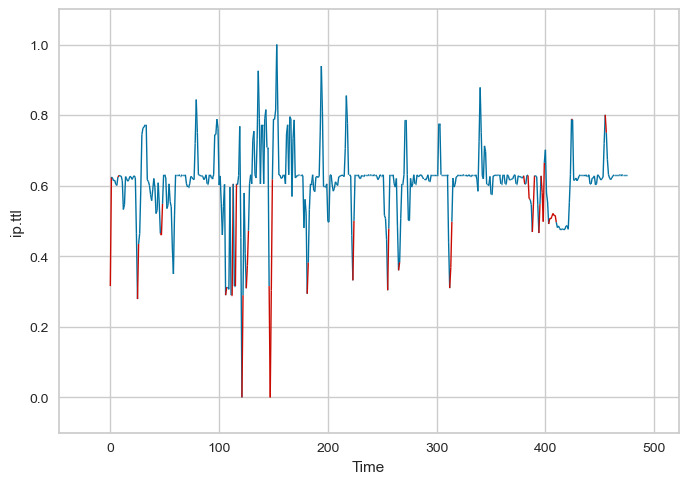

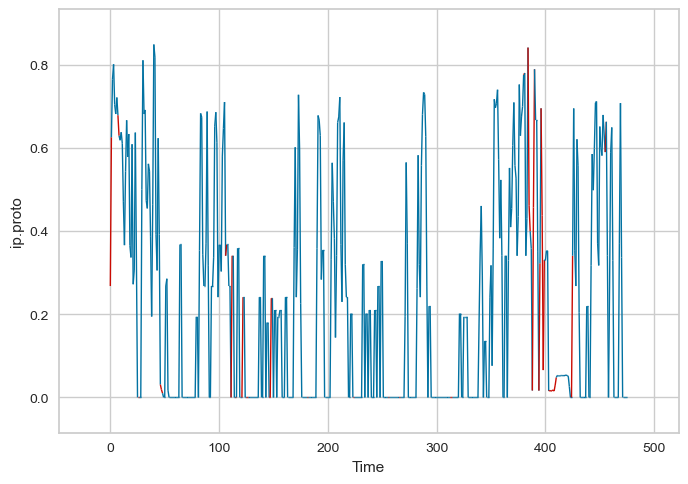

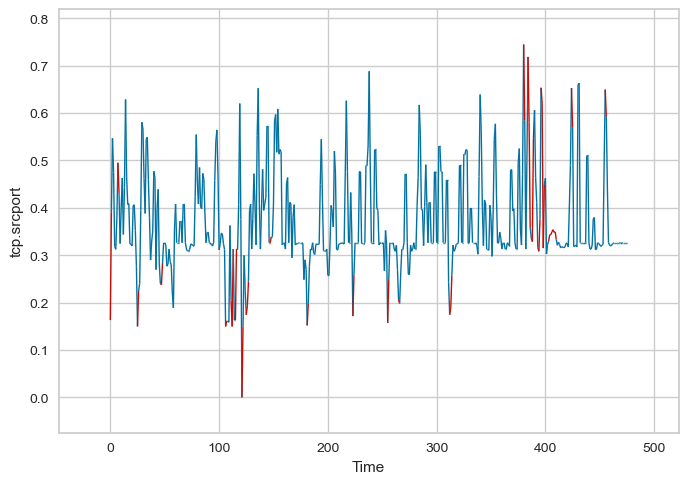

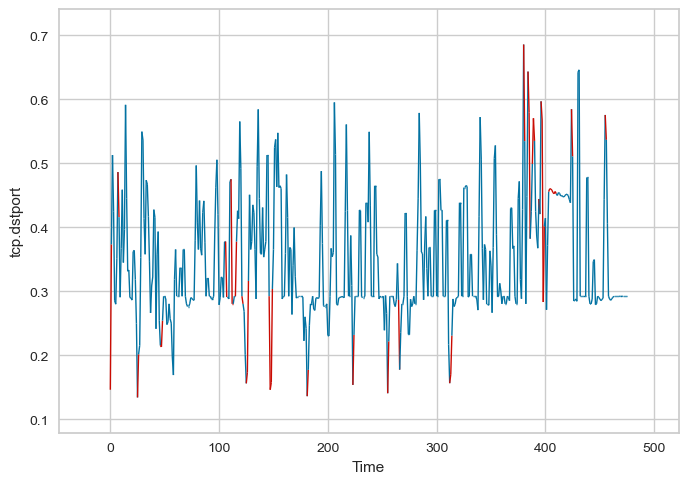

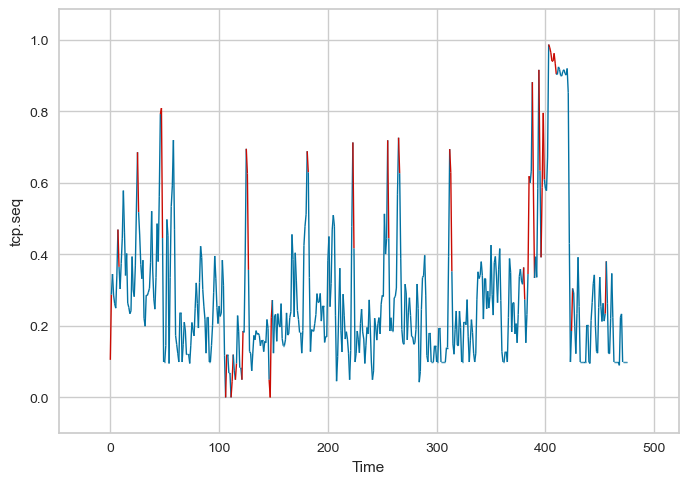

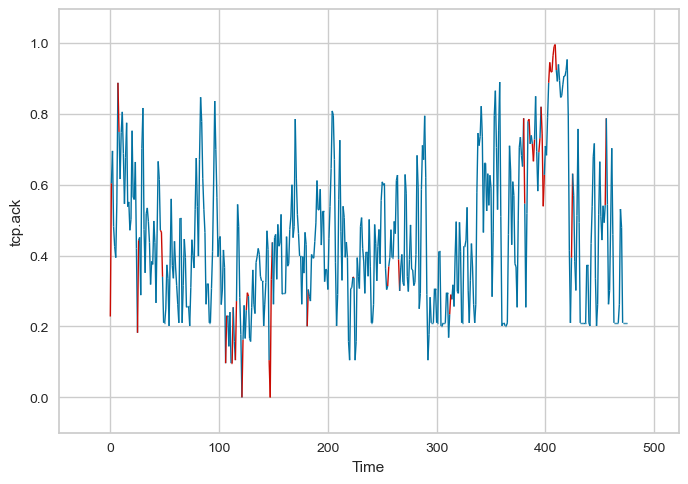

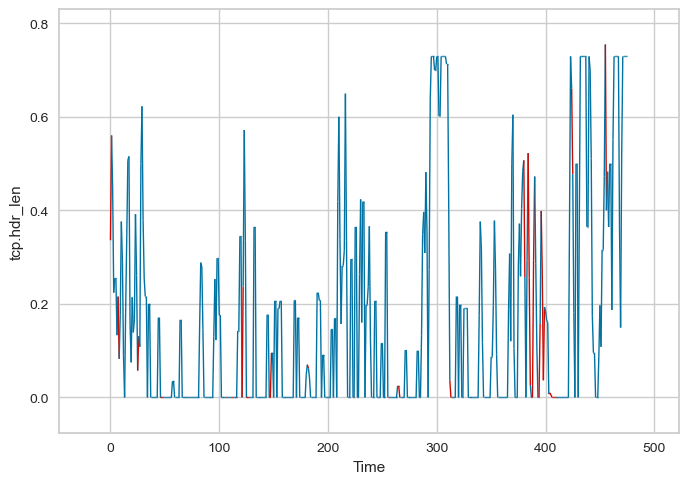

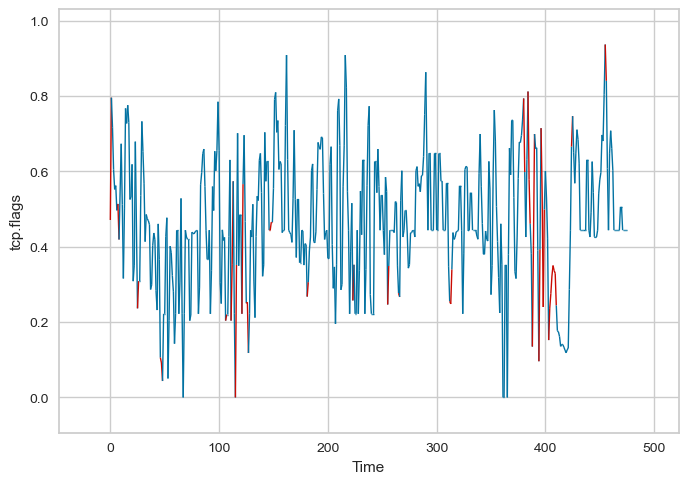

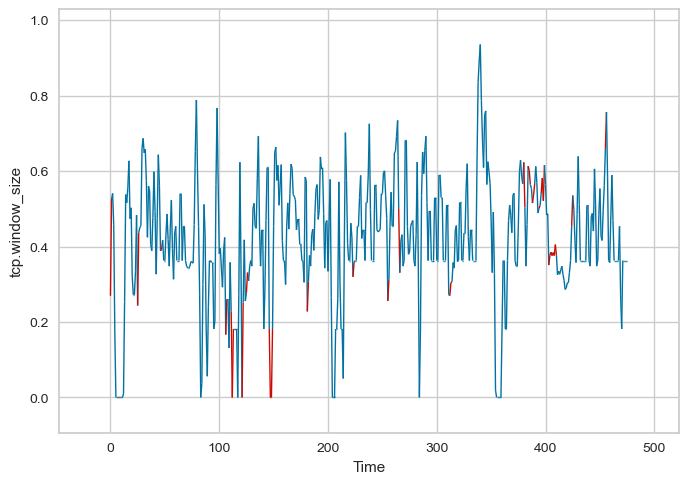

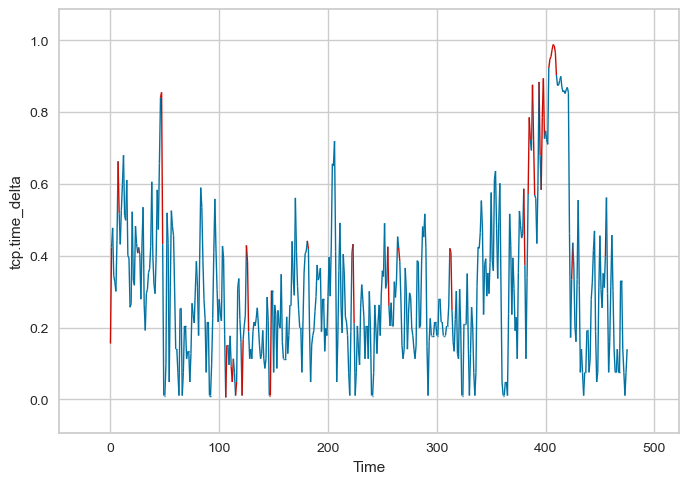

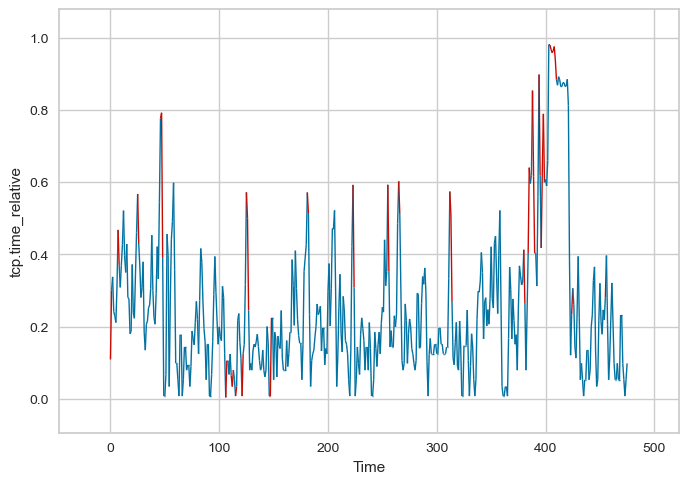

In [15]:
for i in range(1,len(col)-1):
    x = range(smooth_entropy[f].shape[0])
    y = smooth_entropy[f][:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,fp_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

In [16]:
histogram = create_model('histogram', fraction = 0.1)
histogram_result = assign_model(histogram)
anomaly = histogram_result['Anomaly']
anomaly.to_csv('ics_anomaly_value.csv', index=False)
pd.DataFrame(smooth_time).to_csv('ics_true_value.csv', index=False)
# plot = RocCurveDisplay.from_predictions(attack_entropy[:,1],anomaly,pos_label=1,name='ROC curve',linewidth=1.5)
# plot.set_xlabel("False Positive Rate")
# plot.set_ylabel("True Positive Rate")
TP = 0
FP = 0
TN = 0
FN = 0
fp_time = []
fn_time = []
for i in range(smooth_entropy[f].shape[0]):
    if i not in smooth_time[f] and anomaly[i]==0:
        TN += 1
    elif i in smooth_time[f] and anomaly[i]==1:
        TP += 1
    elif i in smooth_time[f] and anomaly[i]==0:
        FN += 1
        fn_time.append(i)
    elif i not in smooth_time[f] and anomaly[i]==1:
        FP += 1
        fp_time.append(i)

print("True positive =",TP)
print("False positive =",FP)
print("True negative =",TN)
print("False negative =",FN)

True positive = 11
False positive = 37
True negative = 377
False negative = 51


In [17]:
plot_model(rf, plot = 'feature')

NameError: name 'rf' is not defined

In [ ]:
plot_model(rf, plot = 'confusion_matrix')

In [ ]:
plot_model(rf, plot = 'boundary', use_train_data = True)